# 目标检测的基础知识

## 边界框

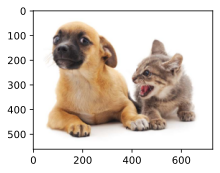

In [1]:
import pandas as pd
import torch
import My_utils
import matplotlib.pyplot as plt
from PIL import Image
My_utils.set_figsize()
img = Image.open('./img/catdog.jpg')
plt.imshow(img)

### 看看之前写的转换函数对不对并绘制框

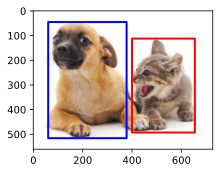

In [2]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
My_utils.box_center_to_corner(My_utils.box_corner_to_center(boxes)) == boxes
fig = plt.imshow(img)
fig.axes.add_patch(My_utils.bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(My_utils.bbox_to_rect(cat_bbox, 'red'))

## 目标检测相关数据集
 http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip

In [3]:
import pandas as pd
import torchvision
import os
def load_banana_data(is_Train=True):
    if is_Train:
        csv_data = pd.read_csv('./banana-detection/bananas_train/label.csv')
    else:
        csv_data = pd.read_csv('./banana-detection/bananas_val/label.csv')
    csv_data = csv_data.set_index('img_name') # 将该csv文件的索引设置为img_name
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join('./banana-detection', 'bananas_train' if is_Train else 'bananas_val', 'images', f'{img_name}')
        ))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256
images, targets = load_banana_data()
print(len(images))
print(targets.shape) # torch.tensor(targets).unsqueeze(1) / 256加了一个维度

1000
torch.Size([1000, 1, 5])


In [4]:
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = load_banana_data(is_train)
    def __getitem__(self, index):
        return self.features[index].float(), self.labels[index]
    def __len__(self):
        return len(self.features)

In [5]:
batch_size = 32
train_iter, val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True), batch_size, shuffle=True),\
    torch.utils.data.DataLoader(BananaDataset(is_train=False), batch_size, shuffle=False)
batch = next(iter(train_iter))
print(batch[0].shape, batch[1].shape) # 批量大小、通道数、宽、高

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


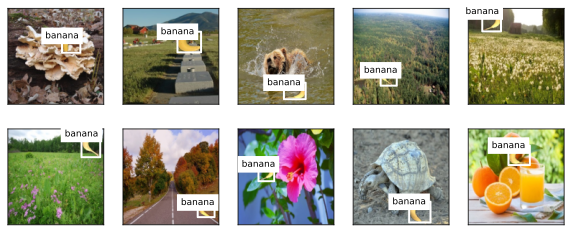

In [7]:
edge_size = 256
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = My_utils.show_image(imgs ,2 ,5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    My_utils.show_bbox(ax, [label[0][1:5] * edge_size], colors=['w'], labels=['banana'])

## 锚框
ground-truth代表监督学习中对于数据集有正确的label
锚框
1.在图片上生成大量的锚框
2.计算锚框和ground-truth边界框围成的区域的交并比
3.并对锚框进行分类，并打上label，是背景类还是预测类

NMS，非极大抑制输出
1.从锚框中选中非背景类的最大预测值
2.去掉和第一步选中的框的IoU大于某个阈值的框
3.重复上述的过程

In [2]:
img = plt.imread('./img/catdog.jpg')
h ,w = img.shape[:2]
print(h ,w)
X = torch.rand(size=(1, 3, h, w))
Y = My_utils.anchor_boxes(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])